In [ ]:
!pip install torch torchvision torch_dct pytorch-wavelets

In [2]:
# ---------------------------------------------------------------------
### IMPORTS ###
# ---------------------------------------------------------------------

import os, math, random, re
from glob import glob
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# external packages required: 
from torch_dct import dct_2d, idct_2d
from pytorch_wavelets import DWTForward, DWTInverse

# ---------------------------------------------------------------------
### GLOBALS AND HYPERPARAMETERS ###
# ---------------------------------------------------------------------

# flags, paths, model and training hyperparams
DEBUG_RUN = False

# Dataset
DATA_ROOT = "datasets/DIV2K"
TRAIN_HR_DIR = os.path.join(DATA_ROOT, "train/HR")
VALID_HR_DIR = os.path.join(DATA_ROOT, "valid/HR")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# Markov chain and network
SCALE = 4
T_STEPS = 15
KAPPA = 2.0
ETA_1_FIXED = 0.008
P_SCHEDULE = 0.3
NUM_CHANNELS = 64 # UNet channels

# Training
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCHS = 380
FREQ_LOSS_WEIGHT = 2.0
SAVE_INTERVAL = 10 # Epochs save weights interval
EVAL_INTERVAL = 10 # Epochs evaluate interval

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 144
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
print(f"Device: {DEVICE}")

# Additional setup - positional encodings and perceptual loss
USE_FOURIER = True
NUM_POS_FREQ = 6
USE_AMPLITUDE = True
AMP_KERNEL = 7
MULTISCALE_SCALES = (1, 2, 4)

USE_VGG_PERCEPTUAL = False
PERCEPTUAL_WEIGHT = 0.05

POS_CHANNELS = (4 * NUM_POS_FREQ) if USE_FOURIER else 0
AMP_CHANNELS = 1 if USE_AMPLITUDE else 0
BASE_IN_CHANNELS = 6 + POS_CHANNELS + AMP_CHANNELS

# Run few epochs mostly to test code
if DEBUG_RUN:
    print("DEBUG RUN: small dataset/epochs for quick test")
    NUM_EPOCHS = 2
    BATCH_SIZE = 4
    EVAL_INTERVAL = 1
    SAVE_INTERVAL = 1

# ---------------------------------------------------------------------
### UTILS ###
# ---------------------------------------------------------------------

# Fourier positional encoding and local amplitude map
def get_2d_fourier_pos_enc(H: int, W: int, n_freqs: int = NUM_POS_FREQ, base: float = 2.0, device=None) -> torch.Tensor:
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ys = torch.linspace(0.0, 1.0, H, device=device)
    xs = torch.linspace(0.0, 1.0, W, device=device)
    grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')  # [H,W]
    coords = torch.stack([grid_x, grid_y], dim=-1)           # [H,W,2]
    freqs = (base ** torch.arange(n_freqs, device=device)) * math.pi
    encs = []
    for f in freqs:
        encs.append(torch.sin(coords * f))
        encs.append(torch.cos(coords * f))
    enc = torch.cat(encs, dim=-1)   # [H,W,4*n_freqs]
    return enc.permute(2, 0, 1).unsqueeze(0)  # [1,C,H,W]


def compute_local_amplitude(x: torch.Tensor, kernel_size: int = AMP_KERNEL, eps: float = 1e-6) -> torch.Tensor:
    # x in [0,1], returns [B,1,H,W] normalized amplitude map
    mu = F.avg_pool2d(x, kernel_size, stride=1, padding=kernel_size//2)
    mu2 = F.avg_pool2d(x * x, kernel_size, stride=1, padding=kernel_size//2)
    var = (mu2 - mu * mu).clamp(min=0.0)
    amp = torch.sqrt(var.mean(dim=1, keepdim=True) + eps)
    B = amp.shape[0]
    flat = amp.view(B, -1)
    amin = flat.min(dim=1)[0].view(B,1,1,1)
    amax = flat.max(dim=1)[0].view(B,1,1,1)
    amp = (amp - amin) / (amax - amin + eps)
    return amp


def multiscale_loss(pred: torch.Tensor, target: torch.Tensor, scales=MULTISCALE_SCALES, spatial_loss_fn=None, freq_weight: float = FREQ_LOSS_WEIGHT, spatial_weight: float = 1.0) -> torch.Tensor:
    # combined L1 spatial + DCT L1 across scales, expects pred/target in [-1,1]
    if spatial_loss_fn is None:
        spatial_loss_fn = nn.L1Loss()
    total = 0.0
    total_weight = 0.0
    pred01 = (pred + 1.0) / 2.0
    target01 = (target + 1.0) / 2.0
    for s in scales:
        if s == 1:
            p_s, t_s = pred01, target01
        else:
            p_s = F.interpolate(pred01, scale_factor=1.0/s, mode='bilinear', align_corners=False)
            t_s = F.interpolate(target01, scale_factor=1.0/s, mode='bilinear', align_corners=False)
        l_spatial = spatial_loss_fn(p_s, t_s)
        p_dct = dct_2d(p_s, norm='ortho')
        t_dct = dct_2d(t_s, norm='ortho')
        l_freq = spatial_loss_fn(p_dct, t_dct)
        weight = 1.0 / float(s)
        total += weight * (spatial_weight * l_spatial + freq_weight * l_freq)
        total_weight += weight
    return total / (total_weight + 1e-12)


# load VGG features if requested
def load_vgg_features(model_name: str = "vgg19_bn", pretrained: bool = True, device: torch.device = torch.device("cpu")):
    try:
        if model_name == "vgg19_bn":
            from torchvision.models import vgg19_bn, VGG19_BN_Weights
            weights = VGG19_BN_Weights.DEFAULT if pretrained else None
            model = vgg19_bn(weights=weights).features.to(device).eval()
        else:
            from torchvision.models import vgg16_bn, VGG16_BN_Weights
            weights = VGG16_BN_Weights.DEFAULT if pretrained else None
            model = vgg16_bn(weights=weights).features.to(device).eval()
    except Exception:
        if model_name == "vgg19_bn":
            from torchvision.models import vgg19_bn
            model = vgg19_bn(pretrained=pretrained).features.to(device).eval()
        else:
            from torchvision.models import vgg16_bn
            model = vgg16_bn(pretrained=pretrained).features.to(device).eval()
    for p in model.parameters():
        p.requires_grad = False
    return model


if USE_VGG_PERCEPTUAL:
    vgg = load_vgg_features(model_name="vgg19_bn", pretrained=True, device=DEVICE)
    def vgg_features(x):
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1,3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1,3,1,1)
        x_norm = (x - mean) / std
        return vgg(x_norm)
    def perceptual_loss(pred, target):
        p = (pred + 1.0) / 2.0
        t = (target + 1.0) / 2.0
        return F.mse_loss(vgg_features(p), vgg_features(t))
else:
    def perceptual_loss(pred, target): return 0.0

# ---------------------------------------------------------------------
### DATASET ###
# ---------------------------------------------------------------------

# DIV2K dataset that returns HR and upsampled LR (y0)
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir: str, crop_size: int = 256, scale: int = SCALE):
        self.paths = sorted(glob(os.path.join(hr_dir, "*.png")))
        self.crop_size = crop_size
        self.scale = scale
        self.transform = T.Compose([T.ToTensor(), T.Normalize(mean=[0.5]*3, std=[0.5]*3)])  # [0,1] -> [-1,1]
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        hr_image = Image.open(self.paths[idx]).convert('RGB')
        w,h = hr_image.size
        if w >= self.crop_size and h >= self.crop_size:
            x = random.randint(0, w - self.crop_size)
            y = random.randint(0, h - self.crop_size)
            hr_patch = hr_image.crop((x,y,x+self.crop_size,y+self.crop_size))
        else:
            hr_patch = hr_image.resize((self.crop_size,self.crop_size), Image.BICUBIC)
        lr_w, lr_h = self.crop_size // self.scale, self.crop_size // self.scale
        lr_patch = hr_patch.resize((lr_w, lr_h), Image.BICUBIC)
        y0_patch = lr_patch.resize((self.crop_size, self.crop_size), Image.BICUBIC)
        hr_tensor = self.transform(hr_patch)
        y0_tensor = self.transform(y0_patch)
        return hr_tensor, y0_tensor


# Dataloaders and positional encoding cache
train_dataset = DIV2KDataset(TRAIN_HR_DIR, crop_size=256, scale=SCALE)
valid_dataset = DIV2KDataset(VALID_HR_DIR, crop_size=256, scale=SCALE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
if DEBUG_RUN:
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

POS_ENC_CACHE = None
def ensure_pos_enc(H: int, W: int):
    global POS_ENC_CACHE
    if POS_ENC_CACHE is None or POS_ENC_CACHE.shape[-2:] != (H,W):
        POS_ENC_CACHE = get_2d_fourier_pos_enc(H, W, n_freqs=NUM_POS_FREQ, device=DEVICE)
    return POS_ENC_CACHE

# ---------------------------------------------------------------------
### NETWORK ###
# ---------------------------------------------------------------------

# Network blocks
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim:int):
        super().__init__()
        self.dim = dim
    def forward(self, t: torch.Tensor):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        freqs = torch.exp(torch.arange(half_dim, device=device) * -emb)
        vals = t[:, None] * freqs[None, :]
        return torch.cat((vals.sin(), vals.cos()), dim=-1)


class ConvBlock(nn.Module):
    def __init__(self, in_channels:int, out_channels:int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)


class DCTBranch(nn.Module):
    def __init__(self, channels:int):
        super().__init__()
        self.process = nn.Sequential(nn.Conv2d(channels, channels, 1), nn.ReLU(inplace=True), nn.Conv2d(channels, channels, 1))
    def forward(self, x):
        x_dct = dct_2d(x, norm='ortho')
        x_dct = self.process(x_dct)
        return idct_2d(x_dct, norm='ortho')


class DWTBranch(nn.Module):
    def __init__(self, channels:int):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar', mode='reflect')
        self.idwt = DWTInverse(wave='haar', mode='reflect')
        self.ll_process = nn.Conv2d(channels, channels, 1)
        self.lh_process = nn.Conv2d(channels, channels, 1)
        self.hl_process = nn.Conv2d(channels, channels, 1)
        self.hh_process = nn.Conv2d(channels, channels, 1)
    def forward(self, x):
        yl, yh = self.dwt(x)
        yl = self.ll_process(yl)
        lh_proc = self.lh_process(yh[0][:, :, 0, :, :])
        hl_proc = self.hl_process(yh[0][:, :, 1, :, :])
        hh_proc = self.hh_process(yh[0][:, :, 2, :, :])
        yh[0] = torch.stack([lh_proc, hl_proc, hh_proc], dim=2)
        return self.idwt((yl, yh))


class DualDomainBlock(nn.Module):
    def __init__(self, channels:int):
        super().__init__()
        self.spatial_branch = ConvBlock(channels, channels)
        self.dct_branch = DCTBranch(channels)
        self.dwt_branch = DWTBranch(channels)
        self.fusion = nn.Conv2d(channels * 3, channels, kernel_size=1)
    def forward(self, x):
        x_spatial = self.spatial_branch(x)
        x_dct = self.dct_branch(x)
        x_dwt = self.dwt_branch(x)
        combined = torch.cat([x_spatial, x_dct, x_dwt], dim=1)
        fused = self.fusion(combined)
        return x + fused


# UNet with time conditioning
class DualDomainUNet(nn.Module):
    def __init__(self, in_channels:int = BASE_IN_CHANNELS, base_channels:int = NUM_CHANNELS, time_dim:int = 128):
        super().__init__()
        self.time_mlp = nn.Sequential(SinusoidalPosEmb(time_dim), nn.Linear(time_dim, time_dim * 4), nn.GELU(), nn.Linear(time_dim * 4, base_channels))
        self.inc = ConvBlock(in_channels, base_channels)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DualDomainBlock(base_channels))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DualDomainBlock(base_channels))
        self.bot = DualDomainBlock(base_channels)
        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), nn.Conv2d(base_channels, base_channels, 1))
        self.dec1 = DualDomainBlock(base_channels * 2)
        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), nn.Conv2d(base_channels * 2, base_channels, 1))
        self.dec2 = DualDomainBlock(base_channels * 2)
        self.outc = nn.Conv2d(base_channels * 2, 3, kernel_size=1)
    def forward(self, xt: torch.Tensor, y0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        if t.dim() > 1: t = t.squeeze(1)
        t = t.to(xt.device).float()
        t_emb = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)
        x_in = torch.cat([xt, y0], dim=1)
        x1 = self.inc(x_in)
        x1 = x1 + t_emb
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x_bot = self.bot(x3)
        x = self.up1(x_bot)
        x = self.dec1(torch.cat([x, x2], dim=1))
        x = self.up2(x)
        x = self.dec2(torch.cat([x, x1], dim=1))
        return self.outc(x)
    
# Noise schedule
def make_eta_schedule(T: int, p: float = P_SCHEDULE, kappa: float = KAPPA) -> np.ndarray:
    eta = np.zeros(T + 1, dtype=np.float32)
    eta[1] = ETA_1_FIXED
    b0 = np.exp(0.5 / (T - 1) * np.log(0.999 / eta[1]))
    for t in range(2, T + 1):
        exponent = ((t-1) / (T-1)) ** p
        eta[t] = (np.sqrt(eta[1]) * (b0 ** ((T - 1) * exponent)))**2
    return eta
eta = torch.from_numpy(make_eta_schedule(T_STEPS, p=P_SCHEDULE, kappa=KAPPA)).to(DEVICE)
alpha = torch.diff(eta, prepend=torch.tensor([0.0], device=DEVICE))


# Augment y0
def augment_y0(y0: torch.Tensor) -> torch.Tensor:
    B,C,H,W = y0.shape
    extras = []
    if USE_FOURIER:
        pos = ensure_pos_enc(H, W).to(y0.device)
        extras.append(pos.repeat(B,1,1,1))
    if USE_AMPLITUDE:
        y0_01 = (y0 + 1.0) / 2.0
        amp = compute_local_amplitude(y0_01, kernel_size=AMP_KERNEL)
        extras.append(amp.to(y0.device))
    return torch.cat([y0] + extras, dim=1) if extras else y0


# Sampling helpers
def sample_xt(x0: torch.Tensor, y0: torch.Tensor, t_idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
    eta_t = eta[t_idx]
    mean = (1 - eta_t) * x0 + eta_t * y0
    noise = torch.randn_like(x0)
    xt = mean + KAPPA * torch.sqrt(eta_t) * noise
    return xt, noise


@torch.no_grad()
def reverse_sample_augmented(y0: torch.Tensor) -> Tuple[torch.Tensor, list]:
    model.eval()
    chain_steps = []
    x_t = y0 + KAPPA * torch.sqrt(eta[T_STEPS]) * torch.randn_like(y0)
    chain_steps.append(x_t)

    for t in range(T_STEPS, 0, -1):
        t_tensor = torch.full((y0.shape[0],), float(t), device=DEVICE)
        y0_aug = augment_y0(y0)
        predicted_residual = model(x_t, y0_aug, t_tensor)
        predicted_x0 = (y0 + predicted_residual).clamp(-1.0, 1.0)  # learn residuals
        eta_t, eta_t_1, alpha_t = eta[t], eta[t-1], alpha[t]
        term1 = (eta_t_1 / eta_t) * x_t
        term2 = (alpha_t / eta_t) * (1 - eta_t_1) * predicted_x0
        term3 = (alpha_t * eta_t_1 / eta_t) * y0
        mu = term1 + term2 + term3
        variance = (KAPPA ** 2) * (eta_t_1 / eta_t) * alpha_t
        x_t = mu + torch.sqrt(variance) * torch.randn_like(x_t) if t > 1 else mu
        if t == (T_STEPS // 2) + 1:
            chain_steps.append(x_t)

    final_sr = (x_t.clamp(-1,1) + 1) / 2.0
    processed_chain = [(step.clamp(-1,1) + 1)/2.0 for step in chain_steps]
    return final_sr, processed_chain

# Evaluation and plotting
@torch.no_grad()
def evaluate_and_plot(model, valid_loader, epoch, n_examples=3):
    model.eval()
    total_psnr_sr, total_psnr_bic, total_ssim = 0.0, 0.0, 0.0
    plot_data = []

    for i, (hr_img, y0_img) in enumerate(valid_loader):
        hr, y0 = hr_img.to(DEVICE), y0_img.to(DEVICE)
        sr_tensor, _ = reverse_sample_augmented(y0)

        hr_np = (hr.squeeze(0).cpu().permute(1,2,0).numpy() + 1)/2.0
        y0_np = (y0.squeeze(0).cpu().permute(1,2,0).numpy() + 1)/2.0
        sr_np = sr_tensor.squeeze(0).cpu().permute(1,2,0).numpy()

        psnr_sr = compare_psnr(hr_np, sr_np, data_range=1.0)
        psnr_bic = compare_psnr(hr_np, y0_np, data_range=1.0)

        win_size = min(7, min(hr_np.shape[:2]))
        ssim = compare_ssim(hr_np, sr_np, data_range=1.0, channel_axis=2, win_size=win_size)

        total_psnr_sr += psnr_sr
        total_psnr_bic += psnr_bic
        total_ssim += ssim

        if i < n_examples:
            plot_data.append({'hr':hr_np, 'lr':y0_np, 'sr':sr_np, 'psnr_sr':psnr_sr, 'ssim':ssim, 'psnr_bic':psnr_bic})

    n = len(valid_loader)
    print(f"Eval Epoch {epoch}: PSNR(SR)={total_psnr_sr/n:.4f}, PSNR(Bic)={total_psnr_bic/n:.4f}, SSIM={total_ssim/n:.4f}")

    fig, axes = plt.subplots(len(plot_data), 3, figsize=(15,5*len(plot_data)))
    if len(plot_data) == 1:
        axes = [axes]

    for i, d in enumerate(plot_data):
        ax_row = axes[i]
        ax_row[0].imshow(d['lr']); ax_row[0].set_title("LR (bic) {:.2f} dB".format(d["psnr_bic"]))
        ax_row[1].imshow(d['sr']); ax_row[1].set_title("SR (final) PSNR: {:.2f} dB, SSIM: {:.4f}".format(d["psnr_sr"], d["ssim"]))
        ax_row[2].imshow(d['hr']); ax_row[2].set_title("HR (Ground Truth)")
        for ax in ax_row:
            ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, "eval_epoch_{}.png".format(epoch))
    plt.savefig(out_path); plt.close()
    print("Saved eval plot to", out_path)

# ---------------------------------------------------------------------
### TRAINING AND CHECKPOINT LOADING ###
# ---------------------------------------------------------------------

model     = DualDomainUNet(in_channels=BASE_IN_CHANNELS, base_channels=NUM_CHANNELS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-7)

RESUME_FROM = None  # or set to path to resume - wieghts name

def save_checkpoint(epoch: int):
    ck = os.path.join(SAVE_DIR, "resshift_epoch_{}.pt".format(epoch))
    torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'scheduler_state': scheduler.state_dict()}, ck)
    print("Saved checkpoint:", ck)


def find_latest_checkpoint() -> str | None:
    candidates = glob(os.path.join(SAVE_DIR, "resshift_epoch_*.pt"))
    if not candidates:
        return None
    best = None
    best_epoch = -1
    for p in candidates:
        m = re.search(r"resshift_epoch_(\d+)\.pt$", p)
        if m:
            e = int(m.group(1))
            if e > best_epoch:
                best_epoch = e
                best = p
    return best


def _move_optimizer_state_to_device(opt_state, device):
    # move optimizer state tensors to device
    for state in list(opt_state.values()):
        for k, v in list(state.items()):
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)


def load_checkpoint(path: str):
    ck = torch.load(path, map_location=DEVICE)
    mfile = re.search(r"resshift_epoch_(\d+)\.pt$", path)
    epoch_from_filename = int(mfile.group(1)) if mfile else None

    start_epoch = 1
    if isinstance(ck, dict):
        model_state = None
        if 'model_state' in ck:
            model_state = ck['model_state']
        elif 'model_state_dict' in ck:
            model_state = ck['model_state_dict']
        elif 'state_dict' in ck:
            model_state = ck['state_dict']

        if model_state is not None:
            model.load_state_dict(model_state)
            if 'optimizer_state' in ck:
                try:
                    optimizer.load_state_dict(ck['optimizer_state'])
                    _move_optimizer_state_to_device(optimizer.state, DEVICE)
                except Exception as e:
                    print("Warning: couldn't load optimizer_state cleanly:", e)
            if 'scheduler_state' in ck:
                try:
                    scheduler.load_state_dict(ck['scheduler_state'])
                except Exception as e:
                    print("Warning: couldn't load scheduler_state cleanly:", e)
            if 'epoch' in ck:
                start_epoch = int(ck.get('epoch', 0)) + 1
            elif epoch_from_filename is not None:
                start_epoch = epoch_from_filename + 1
            else:
                start_epoch = 1
        else:
            # maybe ck is a raw state_dict
            try:
                model.load_state_dict(ck)
                start_epoch = epoch_from_filename + 1 if epoch_from_filename is not None else 1
            except Exception as e:
                raise RuntimeError(f"Unrecognized checkpoint format for '{path}': {e}")
    else:
        try:
            model.load_state_dict(ck)
            start_epoch = epoch_from_filename + 1 if epoch_from_filename is not None else 1
        except Exception as e:
            raise RuntimeError(f"Unrecognized checkpoint format for '{path}': {e}")

    scheduler.last_epoch = max(0, start_epoch - 1)
    print(f"Loaded checkpoint '{path}'. Resuming at epoch {start_epoch}.")
    return start_epoch


start_epoch = 1
latest = RESUME_FROM if RESUME_FROM else find_latest_checkpoint()
if latest is not None:
    try:
        start_epoch = load_checkpoint(latest)
    except Exception as e:
        print("Failed to load checkpoint:", e)
        print("Starting from scratch.")
        start_epoch = 1
else:
    print("No checkpoint found. Starting from scratch.")

def run_training():
    print("Starting training...")
    global start_epoch
    for epoch in range(start_epoch, NUM_EPOCHS+1):
        model.train()
        total_loss = 0.0
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")

        for batch_idx, (x0_batch, y0_batch) in enumerate(pbar):
            x0, y0 = x0_batch.to(DEVICE), y0_batch.to(DEVICE)
            t_indices = torch.randint(1, T_STEPS + 1, (x0.shape[0],), device=DEVICE)

            xt_list, noise_list = [], []
            for i, t in enumerate(t_indices):
                xt, noise = sample_xt(x0[i:i+1], y0[i:i+1], t.item())
                xt_list.append(xt)
                noise_list.append(noise)
            xt = torch.cat(xt_list, dim=0)

            y0_aug = augment_y0(y0)

            # model predicts residual (x0 - y0)
            predicted_residual = model(xt, y0_aug, t_indices.float())
            predicted_x0 = y0 + predicted_residual

            loss_ms = multiscale_loss(predicted_x0, x0, scales=MULTISCALE_SCALES, spatial_loss_fn=nn.L1Loss(), freq_weight=FREQ_LOSS_WEIGHT)
            loss_perc = PERCEPTUAL_WEIGHT * perceptual_loss(predicted_x0, x0) if USE_VGG_PERCEPTUAL else 0.0
            loss = loss_ms + loss_perc

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch} done. Avg loss: {avg_loss:.5f}")

        scheduler.step()

        if epoch % EVAL_INTERVAL == 0 and epoch > 0:
            evaluate_and_plot(model, valid_dataloader, epoch)

        if epoch % SAVE_INTERVAL == 0 and epoch > 0:
            save_checkpoint(epoch)

    final_ck = os.path.join(SAVE_DIR, "resshift_final.pt")
    torch.save({
        'epoch': NUM_EPOCHS,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
    }, final_ck)
    print("Training finished. Final model saved to", final_ck)

# ---------------------------------------------------------------------
### RUN AND EVALUATE ###
# ---------------------------------------------------------------------

print("Ready. Model summary:")
with torch.no_grad():
    xt_test = torch.randn(1,3,256,256, device=DEVICE)
    y0_test = torch.randn(1,3,256,256, device=DEVICE)
    ensure_pos_enc(256, 256)
    y0_aug_test = augment_y0(y0_test)
    t_test = torch.tensor([1.0], device=DEVICE)
    out = model(xt_test, y0_aug_test, t_test)
    print("Forward pass OK. Output shape:", out.shape)

run_training()

Device: cuda
Loaded checkpoint 'checkpoints/resshift_epoch_380.pt'. Resuming at epoch 381.
Ready. Model summary:
Forward pass OK. Output shape: torch.Size([1, 3, 256, 256])
Starting training...
Training finished. Final model saved to checkpoints/resshift_final.pt


Loaded checkpoint 'checkpoints/resshift_epoch_380.pt'. Resuming at epoch 381.
Evaluation settings: T=15, p_schedule=0.3, kappa=0.8, mode=stochastic, samples_per_image=1


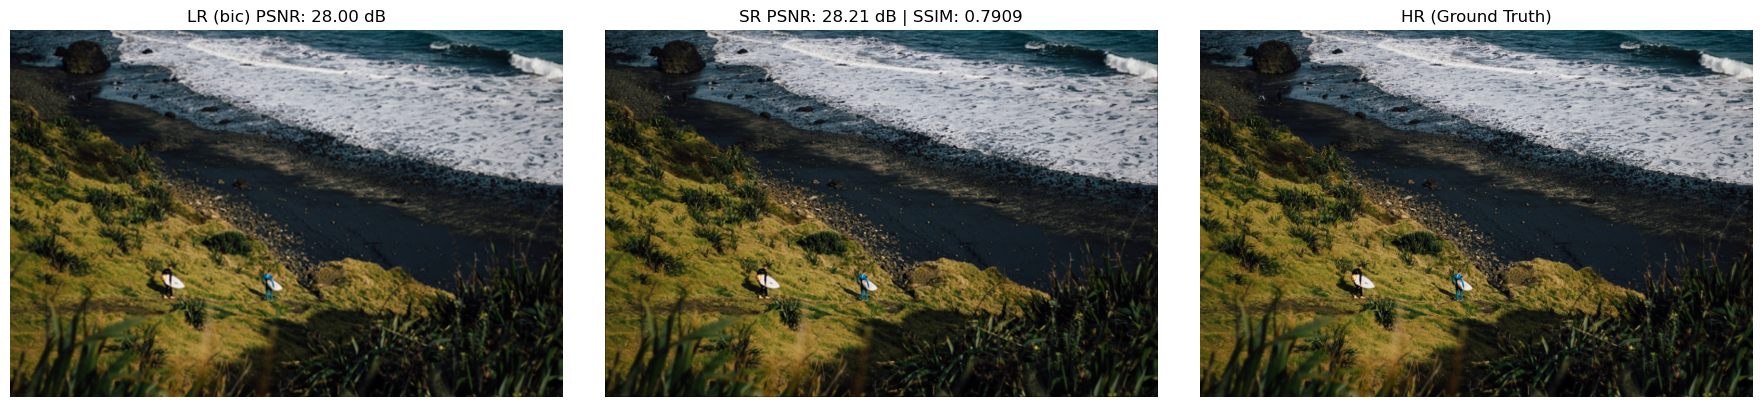

Saved evaluation figure to: checkpoints/latest_eval_full.png
Image 1 (0811.png): Bicubic PSNR=28.00 dB | SR PSNR=28.21 dB | SSIM=0.7909


In [6]:
import random
import os
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# ---------------------------------------------------------------------
### CONFIGURABLE EVALUATION OPTIONS ###
# ---------------------------------------------------------------------
NUM_EVAL_IMAGES = 1                  # random validation images to evaluate
OUT_PATH = os.path.join(SAVE_DIR, "latest_eval_full.png")
SAVE_INDIVIDUAL = True               # save individual SR images into SAVE_DIR
NUM_SAMPLES_PER_IMAGE = 1            # stochastic repetitions per image

# Sampling / chain parameters (None = use trained value)
OVERRIDE_T_STEPS = 15
OVERRIDE_P_SCHEDULE = 0.3
OVERRIDE_KAPPA = 0.8
SAMPLE_MODE = "stochastic"           # 'stochastic' or 'deterministic'
SHOW_CHAIN = False                   # capture and show mid-chain image
CHAIN_CAPTURE_AT = "mid"             # 'mid' or integer step to capture
RANDOM_SEED = None

# Tiling fallback settings for large images / OOM
USE_TILING_FALLBACK = True
TILE_SIZE = 1024
TILE_OVERLAP = 64

# ---------------------------------------------------------------------
### LOAD CHECKPOINT / WEIGHTS ###
# ---------------------------------------------------------------------
if RANDOM_SEED is not None:
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)

latest_ckpt = find_latest_checkpoint()
if latest_ckpt is not None:
    try:
        _ = load_checkpoint(latest_ckpt)
    except Exception as e:
        print("Warning: failed to load latest checkpoint:", e)
else:
    print("No checkpoint found — using current in-memory model weights.")

# build eval sampling params (use overrides if provided)
EVAL_T_STEPS = OVERRIDE_T_STEPS if OVERRIDE_T_STEPS is not None else T_STEPS
EVAL_P_SCHEDULE = OVERRIDE_P_SCHEDULE if OVERRIDE_P_SCHEDULE is not None else P_SCHEDULE
EVAL_KAPPA = OVERRIDE_KAPPA if OVERRIDE_KAPPA is not None else KAPPA

print(
    f"Evaluation settings: T={EVAL_T_STEPS}, p_schedule={EVAL_P_SCHEDULE}, "
    f"kappa={EVAL_KAPPA}, mode={SAMPLE_MODE}, samples_per_image={NUM_SAMPLES_PER_IMAGE}"
)

# create eta/alpha schedules for evaluation
eta_eval = make_eta_schedule(EVAL_T_STEPS, p=EVAL_P_SCHEDULE, kappa=EVAL_KAPPA)
alpha_eval = np.diff(eta_eval, prepend=0.0)
ETA_TORCH = torch.from_numpy(eta_eval.astype(np.float32)).to(DEVICE)
ALPHA_TORCH = torch.from_numpy(alpha_eval.astype(np.float32)).to(DEVICE)

# ---------------------------------------------------------------------
### REVERSE SAMPLING FOR EVALUATION ###
# ---------------------------------------------------------------------
@torch.no_grad()
def reverse_sample_eval(
    y0_tensor: torch.Tensor,
    model: torch.nn.Module,
    T_steps: int = EVAL_T_STEPS,
    eta_arr: torch.Tensor = ETA_TORCH,
    alpha_arr: torch.Tensor = ALPHA_TORCH,
    kappa: float = EVAL_KAPPA,
    stochastic: bool = True,
    capture_chain: bool = SHOW_CHAIN,
    capture_at: str = CHAIN_CAPTURE_AT,
):
    """
    Run reverse sampling and return (final_sr [B,3,H,W] in [0,1], captured_chain_list).
    - eta_arr length should be T_steps+1 (index 0..T_steps)
    - alpha_arr same length
    """
    batch = y0_tensor.shape[0]
    device = y0_tensor.device
    captured = []

    # initial x_T
    if stochastic:
        x_t = y0_tensor + kappa * torch.sqrt(eta_arr[T_steps]) * torch.randn_like(y0_tensor)
    else:
        x_t = y0_tensor.clone()

    if capture_chain:
        captured.append((x_t.clamp(-1, 1) + 1) / 2.0)

    for t in range(T_steps, 0, -1):
        t_vec = torch.full((batch,), float(t), device=device)

        y0_aug = augment_y0(y0_tensor)  # augmentation used by the model

        # model predicts residual = (x0 - y0)
        predicted_residual = model(x_t, y0_aug, t_vec)
        predicted_x0 = (y0_tensor + predicted_residual).clamp(-1.0, 1.0)

        eta_t = eta_arr[t]
        eta_t_1 = eta_arr[t - 1]
        alpha_t = alpha_arr[t]

        term1 = (eta_t_1 / eta_t) * x_t
        term2 = (alpha_t / eta_t) * (1 - eta_t_1) * predicted_x0
        term3 = (alpha_t * eta_t_1 / eta_t) * y0_tensor
        mu = term1 + term2 + term3

        variance = (kappa ** 2) * (eta_t_1 / eta_t) * alpha_t

        if stochastic and t > 1:
            x_t = mu + torch.sqrt(variance) * torch.randn_like(mu)
        else:
            x_t = mu

        # optionally capture a mid-chain image
        if capture_chain:
            if capture_at == "mid" and t == (T_steps // 2) + 1:
                captured.append((x_t.clamp(-1, 1) + 1) / 2.0)
            elif isinstance(capture_at, int) and t == int(capture_at):
                captured.append((x_t.clamp(-1, 1) + 1) / 2.0)

    final_sr = (x_t.clamp(-1, 1) + 1) / 2.0
    # convert captured tensors -> numpy arrays on CPU (list of [B,H,W,3])
    processed_chain = [step.clamp(0, 1).cpu().permute(0, 2, 3, 1).numpy() for step in captured]
    return final_sr, processed_chain

# ---------------------------------------------------------------------
### IMAGE CONVERSION AND FULL / TILED SR ###
# ---------------------------------------------------------------------
def tensor_to_uint8_image(t: np.ndarray) -> np.ndarray:
    """expects HxWx3 float in [0,1], returns uint8 image"""
    return (np.clip(t, 0, 1) * 255.0).round().astype(np.uint8)


@torch.no_grad()
def run_sr_full_image(
    y0_tensor: torch.Tensor,
    hr_shape: Tuple[int, int],
    model: torch.nn.Module,
    single_pass_threshold: int = 2000,
):
    """
    Try single-pass SR for the full image; fallback to tiled SR when needed.
    y0_tensor: [C,H,W] in [-1,1]
    hr_shape: (H, W)
    returns: (sr_np HxWx3 in [0,1], chains list)
    """
    C, H, W = y0_tensor.shape
    try_single = max(H, W) <= single_pass_threshold

    if try_single:
        try:
            y0_b = y0_tensor.unsqueeze(0).to(DEVICE)
            final_sr, chain = reverse_sample_eval(
                y0_b,
                model,
                T_steps=EVAL_T_STEPS,
                eta_arr=ETA_TORCH,
                alpha_arr=ALPHA_TORCH,
                kappa=EVAL_KAPPA,
                stochastic=(SAMPLE_MODE == "stochastic"),
                capture_chain=SHOW_CHAIN,
            )
            sr_np = final_sr.squeeze(0).cpu().permute(1, 2, 0).numpy()
            return sr_np, chain
        except RuntimeError as e:
            print("Single-pass OOM or error, falling back to tiled inference:", e)
            torch.cuda.empty_cache()

    if not USE_TILING_FALLBACK:
        raise RuntimeError("Image too large for single-pass and tiling fallback disabled.")

    # tiled inference
    tile = TILE_SIZE
    overlap = TILE_OVERLAP
    stride = tile - overlap

    acc = np.zeros((H, W, 3), dtype=np.float32)
    weight_acc = np.zeros((H, W, 3), dtype=np.float32)

    # y0 as numpy array in CxHxW
    y0_np_full = y0_tensor.cpu().numpy()

    ys = list(range(0, H, stride))
    xs = list(range(0, W, stride))

    for y in ys:
        for x in xs:
            y1 = min(y + tile, H)
            x1 = min(x + tile, W)
            y0s = max(0, y1 - tile)
            x0s = max(0, x1 - tile)
            tile_slice = y0_np_full[:, y0s:y1, x0s:x1]
            tile_tensor = torch.from_numpy(tile_slice).unsqueeze(0).to(DEVICE)

            try:
                final_sr_tile, _ = reverse_sample_eval(
                    tile_tensor,
                    model,
                    T_steps=EVAL_T_STEPS,
                    eta_arr=ETA_TORCH,
                    alpha_arr=ALPHA_TORCH,
                    kappa=EVAL_KAPPA,
                    stochastic=(SAMPLE_MODE == "stochastic"),
                    capture_chain=False,
                )
            except RuntimeError as e:
                print("Tile inference OOM/error at", (x0s, y0s, x1, y1), e)
                torch.cuda.empty_cache()
                raise

            sr_tile = final_sr_tile.squeeze(0).cpu().permute(1, 2, 0).numpy()
            h_t, w_t = sr_tile.shape[:2]

            # blending weights (Hann window)
            wy = np.hanning(h_t) if h_t > 1 else np.ones(h_t)
            wx = np.hanning(w_t) if w_t > 1 else np.ones(w_t)
            w2d = np.outer(wy, wx).astype(np.float32)[:, :, None]

            acc[y0s:y1, x0s:x1, :] += sr_tile * w2d
            weight_acc[y0s:y1, x0s:x1, :] += w2d

    sr_full = acc / (weight_acc + 1e-8)
    return sr_full, []

# ---------------------------------------------------------------------
### EVALUATE RANDOM SAMPLES ###
# ---------------------------------------------------------------------
model.eval()

n_val = len(valid_dataset)
indices = random.sample(range(n_val), k=min(NUM_EVAL_IMAGES, n_val))
results = []

with torch.no_grad():
    for i_idx, idx in enumerate(indices):
        # load HR image and build LR->Y0 via bicubic down/up
        hr_path = valid_dataset.paths[idx]
        hr_img = Image.open(hr_path).convert("RGB")
        W, H = hr_img.size

        lr_img = hr_img.resize((max(1, W // SCALE), max(1, H // SCALE)), Image.BICUBIC)
        y0_img = lr_img.resize((W, H), Image.BICUBIC)

        hr_tensor = valid_dataset.transform(hr_img)   # [3,H,W] in [-1,1]
        y0_tensor = valid_dataset.transform(y0_img)

        try:
            sr_np, chains = run_sr_full_image(y0_tensor, (H, W), model)
        except Exception as e:
            print(f"Failed to SR full image {hr_path}: {e}")
            continue

        hr_np = (hr_tensor.cpu().permute(1, 2, 0).numpy() + 1.0) / 2.0
        y0_np = (y0_tensor.cpu().permute(1, 2, 0).numpy() + 1.0) / 2.0

        # metrics
        data_range = 1.0
        psnr_sr = compare_psnr(hr_np, sr_np, data_range=data_range)
        psnr_bic = compare_psnr(hr_np, y0_np, data_range=data_range)

        H0, W0 = hr_np.shape[:2]
        win_size = min(7, H0, W0)
        if win_size % 2 == 0:
            win_size -= 1
        try:
            ssim_sr = compare_ssim(hr_np, sr_np, data_range=data_range, channel_axis=2, win_size=win_size)
        except Exception:
            ssim_sr = compare_ssim(hr_np, sr_np, data_range=data_range, channel_axis=2)

        results.append(
            {
                "hr": hr_np,
                "lr": y0_np,
                "sr": sr_np,
                "psnr_sr": psnr_sr,
                "psnr_bic": psnr_bic,
                "ssim_sr": ssim_sr,
                "path": hr_path,
                "chains": chains,
            }
        )

        if SAVE_INDIVIDUAL:
            save_name = os.path.join(SAVE_DIR, f"eval_full_{os.path.basename(hr_path)}")
            plt.imsave(save_name, np.clip(sr_np, 0, 1))

# ---------------------------------------------------------------------
### PLOT RESULTS ###
# ---------------------------------------------------------------------
n = len(results)
if n == 0:
    print("No results to show.")
else:
    rows = n
    cols = 3 if not SHOW_CHAIN else 4
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    if n == 1:
        axes = [axes]

    for i, r in enumerate(results):
        row_axes = axes[i]
        ax0 = row_axes[0]
        ax0.imshow(r["lr"])
        ax0.set_title(f'LR (bic) PSNR: {r["psnr_bic"]:.2f} dB')
        ax0.axis("off")

        ax1 = row_axes[1]
        ax1.imshow(r["sr"])
        ax1.set_title(f'SR PSNR: {r["psnr_sr"]:.2f} dB | SSIM: {r["ssim_sr"]:.4f}')
        ax1.axis("off")

        ax2 = row_axes[2]
        ax2.imshow(r["hr"])
        ax2.set_title("HR (Ground Truth)")
        ax2.axis("off")

        if SHOW_CHAIN:
            ax3 = row_axes[3]
            if len(r["chains"]) > 0 and len(r["chains"][0]) > 0:
                ch = r["chains"][0][0]
                ax3.imshow(ch[0])
                ax3.set_title("Captured chain (first sample)")
                ax3.axis("off")
            else:
                ax3.text(0.5, 0.5, "No chain captured", ha="center", va="center")
                ax3.axis("off")

    plt.tight_layout()
    plt.savefig(OUT_PATH)
    plt.show()
    print(f"Saved evaluation figure to: {OUT_PATH}")

    # print summary metrics
    for i, r in enumerate(results):
        print(
            f"Image {i+1} ({os.path.basename(r['path'])}): "
            f"Bicubic PSNR={r['psnr_bic']:.2f} dB | SR PSNR={r['psnr_sr']:.2f} dB | SSIM={r['ssim_sr']:.4f}"
        )
